In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')

# Load dataset

In [ ]:
iris = load_iris()
X= pd.DataFrame(iris.data, columns = ['sepal_length','sepal_width','petal_length','petal_width'])
y=iris.target

# Check for missing values

In [ ]:
X.isnull().sum()

,0
sepal_length,0
sepal_width,0
petal_length,0
petal_width,0


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
 X.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


# Pairplot

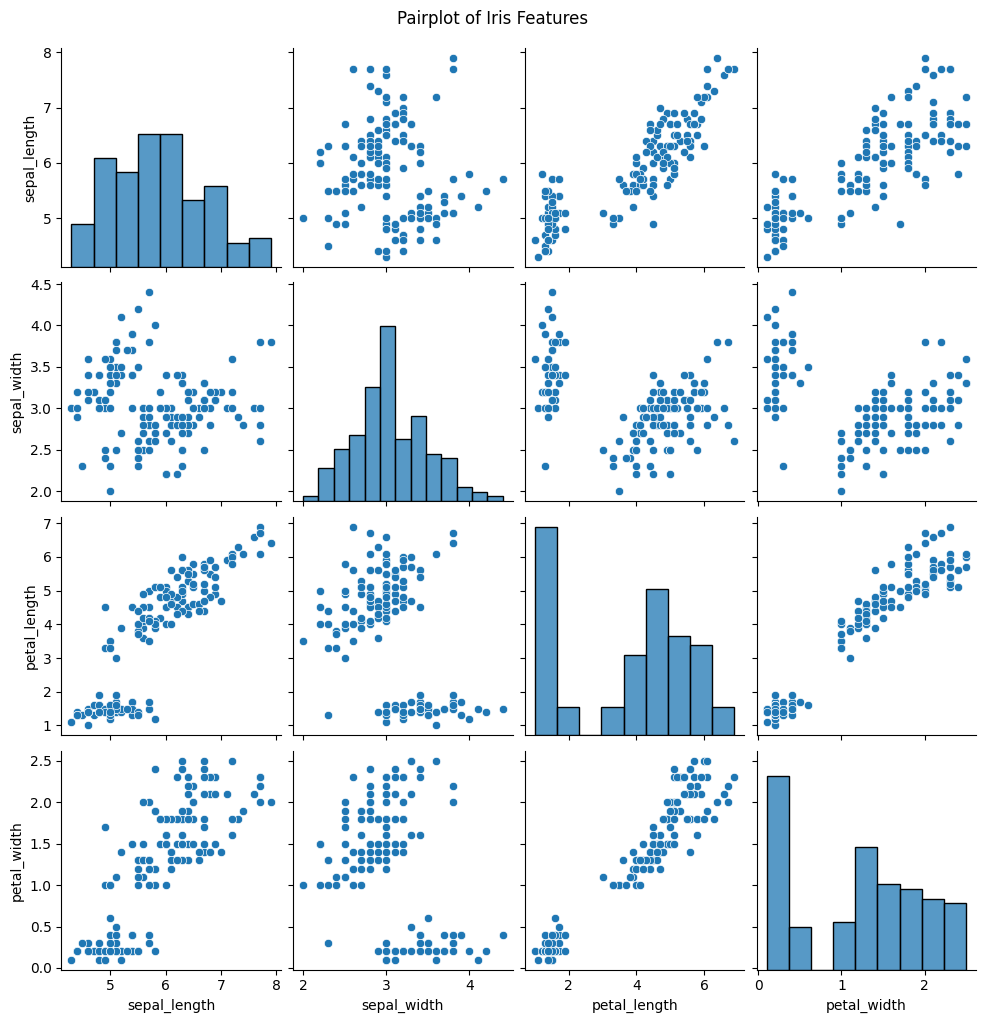

In [ ]:
sns.pairplot(X, diag_kind='hist')
plt.suptitle('Pairplot of Iris Features', y=1.02)
plt.show()

# Correlation heatmap

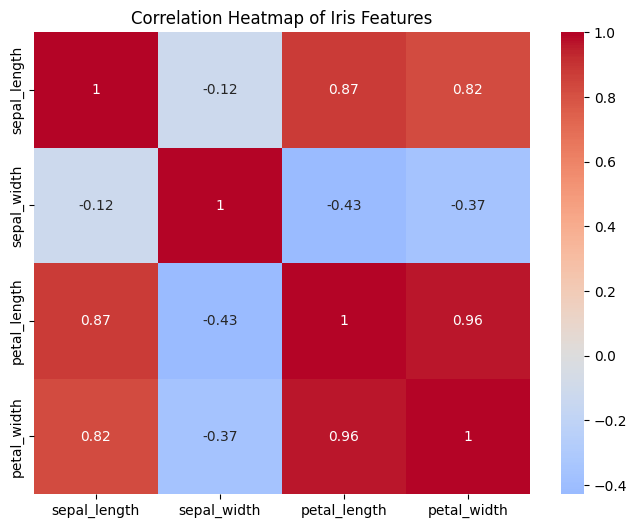

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Iris Features')
plt.show()

# Clustering Algorithms
# 1. K-Means(Elbow Method)


In [ ]:
inertias = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve

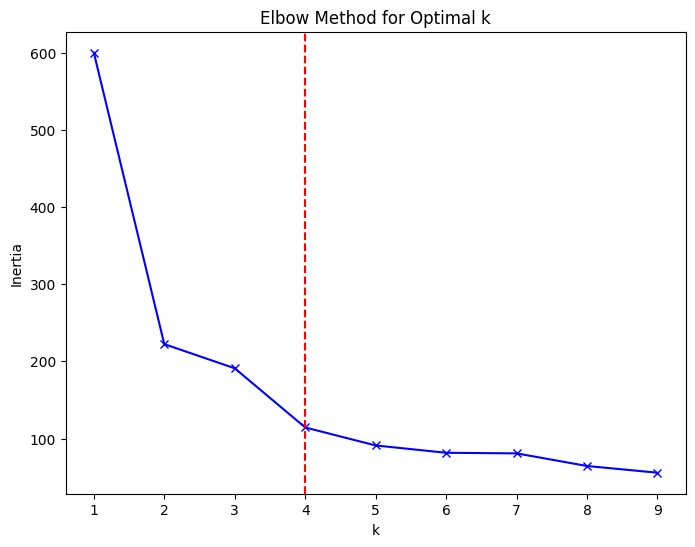

Optimal k: 4


In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
kneedle = KneeLocator(K, inertias, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow
plt.axvline(x=optimal_k, color='r', linestyle='--')
plt.show()
print(f"Optimal k: {optimal_k}")

# K-Means with optimal k

In [ ]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# PCA for visualization

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_.sum()

# Visualization K-Means clusters

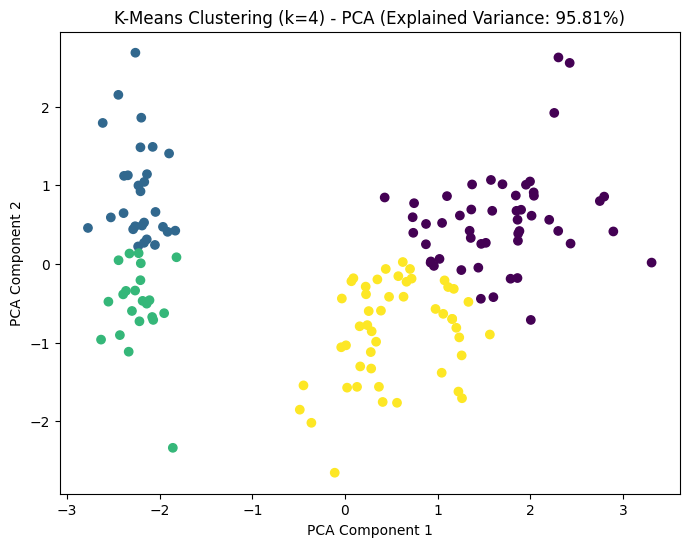

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title(f'K-Means Clustering (k={optimal_k}) - PCA (Explained Variance: {explained_variance:.2%})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 2. Hierarchical Clustering(Dendrogram)

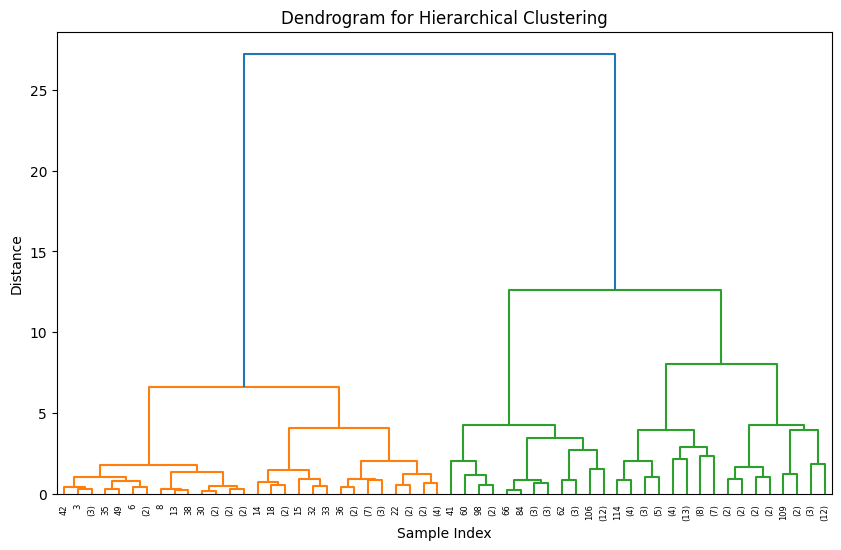

In [ ]:
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Hierarchical Clustering with 3 clusters

In [ ]:
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hc_labels = hc.fit_predict(X_scaled)

# Visualize Hierarchical clusters

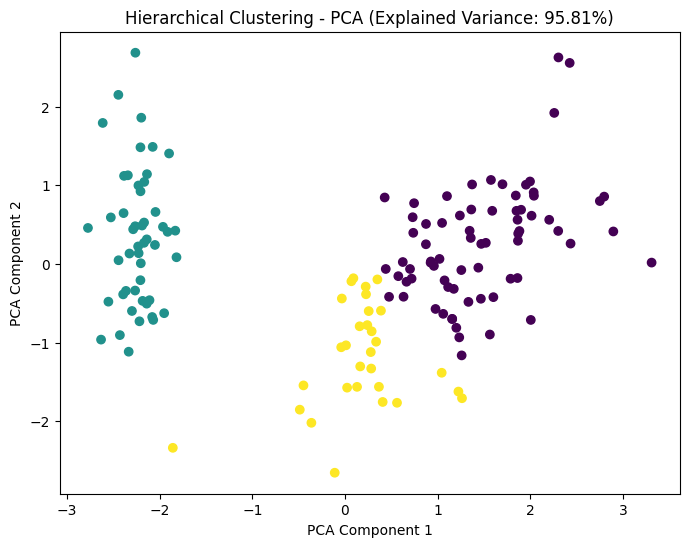

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hc_labels, cmap='viridis')
plt.title(f'Hierarchical Clustering - PCA (Explained Variance: {explained_variance:.2%})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 3. DBSCAN
# k-distance graph for eps

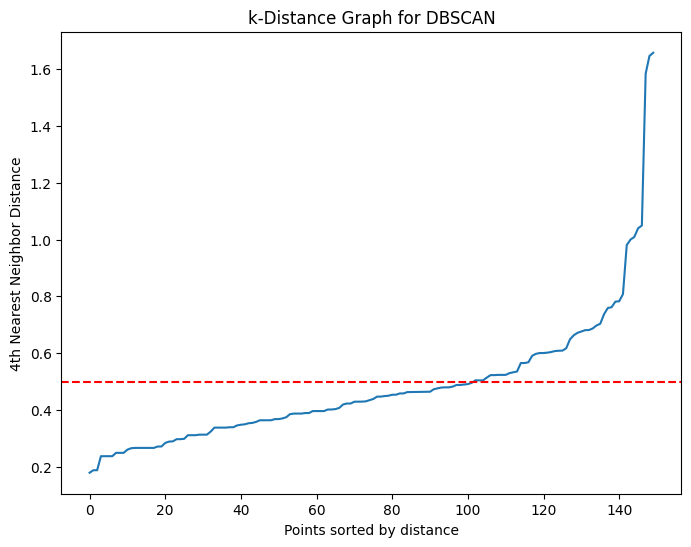

In [ ]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 3], axis=0)

plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('k-Distance Graph for DBSCAN')
plt.xlabel('Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

# DBSCAN clustering

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Visualize DBSCAN clusters

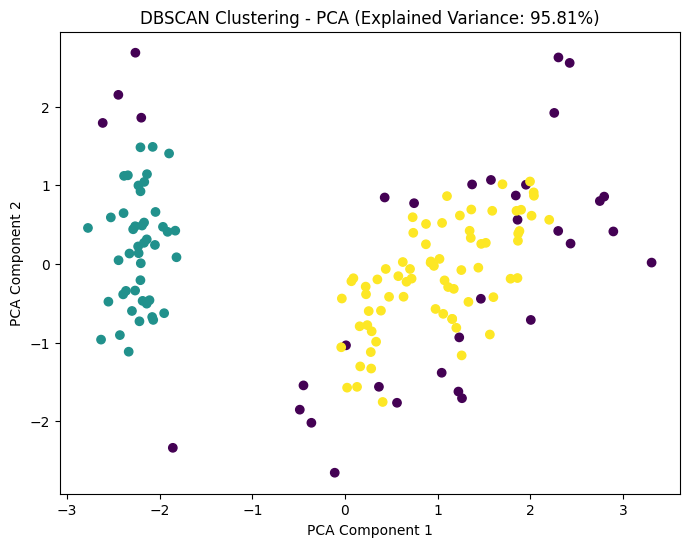

Number of noise points: 34


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.title(f'DBSCAN Clustering - PCA (Explained Variance: {explained_variance:.2%})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()
print(f"Number of noise points: {(dbscan_labels == -1).sum()}")

# Confusion Matrices

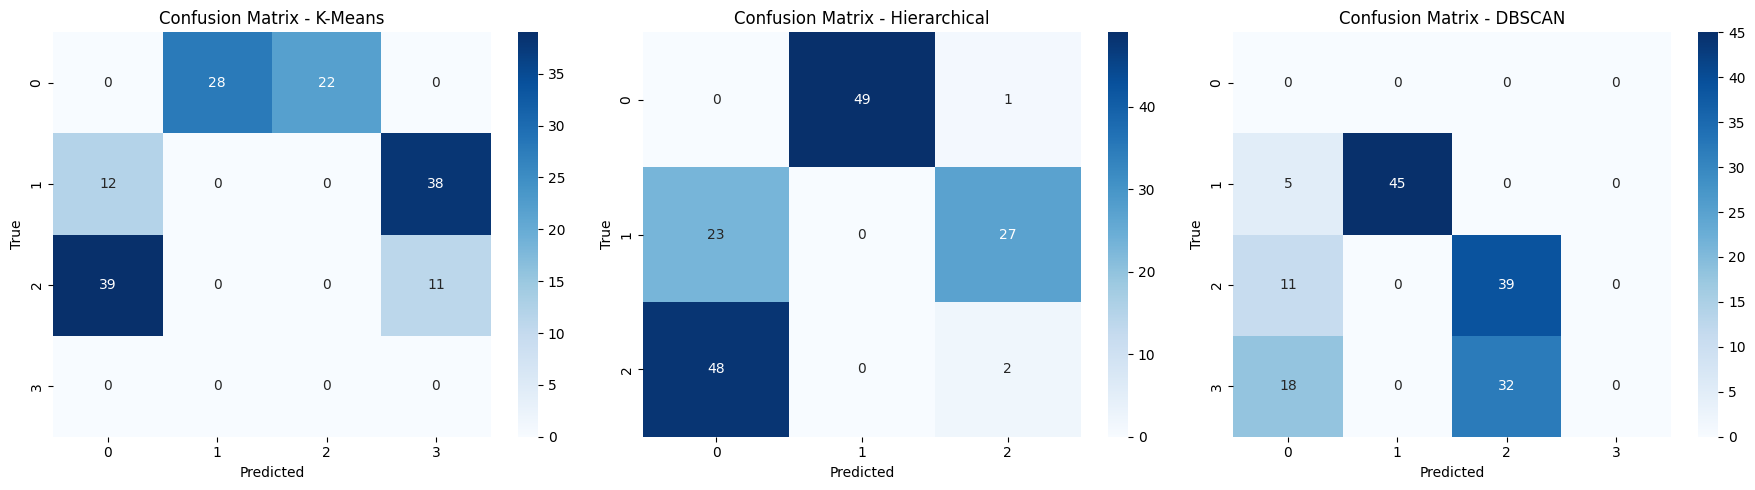

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (labels, title) in enumerate([(kmeans_labels, 'K-Means'), (hc_labels, 'Hierarchical'), (dbscan_labels, 'DBSCAN')]):
    cm = confusion_matrix(y, labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {title}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
plt.tight_layout()
plt.show()

# Evaluation & Compare with true labels

In [ ]:
print("\nAdjusted Rand Index Scores:")
print(f"K-Means: {adjusted_rand_score(y, kmeans_labels):.3f}")
print(f"Hierarchical: {adjusted_rand_score(y, hc_labels):.3f}")
print(f"DBSCAN: {adjusted_rand_score(y, dbscan_labels):.3f}")



Adjusted Rand Index Scores:
K-Means: 0.495
Hierarchical: 0.615
DBSCAN: 0.442


# Calculate ARI scores for each model

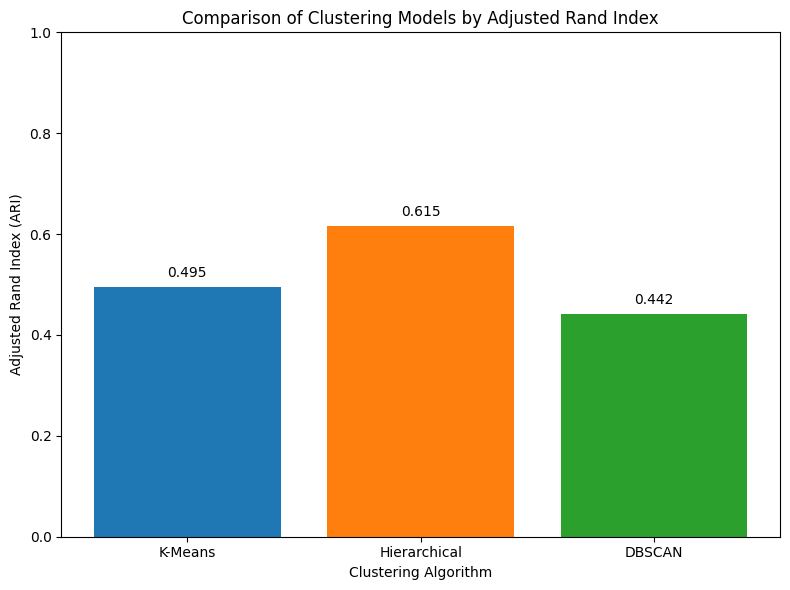

In [ ]:
ari_kmeans = adjusted_rand_score(y, kmeans_labels)
ari_hc = adjusted_rand_score(y, hc_labels)
ari_dbscan = adjusted_rand_score(y, dbscan_labels)

# Data for bar chart
models = ['K-Means', 'Hierarchical', 'DBSCAN']
ari_scores = [ari_kmeans, ari_hc, ari_dbscan]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, ari_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Comparison of Clustering Models by Adjusted Rand Index')
plt.xlabel('Clustering Algorithm')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.ylim(0, 1)  # ARI ranges from -1 to 1, but typically positive for good clustering
for i, score in enumerate(ari_scores):
    plt.text(i, score + 0.02, f'{score:.3f}', ha='center')
plt.tight_layout()
plt.show()